In [1]:
!pip install pretty_midi -q

In [2]:
import numpy as np
import tensorflow as tf
import pretty_midi
import os
import pathlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import collections

from tokenizers.models import BPE
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import Sequence, Lowercase
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.trainers import BpeTrainer
from transformers import GPT2TokenizerFast, GPT2Config,TFGPT2LMHeadModel

2023-01-13 09:40:41.004391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:40:41.005473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:40:41.006146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:40:41.008850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
print(tf. __version__)

2.6.4


In [4]:
# random_seed = 42
# tf.random.set_seed(random_seed)
# np.random.seed(random_seed)

AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    print('Not running on TPU')
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync
    print('batch size =', BATCH_SIZE)
else:
    strategy = tf.distribute.get_strategy() 
    BATCH_SIZE = 64

print("REPLICAS: ", strategy.num_replicas_in_sync)

NUMBER_OF_PIANO_NOTES = 128
SEQ_LENGTH = 100

Not running on TPU
REPLICAS:  1


In [5]:
def get_filenames(directory):
    filenames = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            filenames.append(f)
    return filenames

def load_roll(path):
    return np.load(path, allow_pickle=True)

def save_roll(array_map, path):
    np.savez_compressed(path, **array_map)

def save_string_notes(directory, name):
    filenames = get_filenames(directory)
    saved_rolls = {}
    files_saved = 0
    for index, filename in enumerate(tqdm(filenames)):
        pm = pretty_midi.PrettyMIDI(filename)
        notes = []
        try:
            instrument = pm.instruments[0]
        except IndexError:
            print("Skipped")
            continue
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        if len(sorted_notes) > 100:
            prev_start = sorted_notes[0].start
            for note in sorted_notes:
                notes.append(note.pitch)
            saved_rolls[str(index)] = np.array(notes)
        if len(saved_rolls) % 5000 == 0 and len(saved_rolls) != 0:
            files_saved += 1
            save_roll(saved_rolls, name)
            print(f"Saved file {name}")
            saved_rolls = {}
    if len(saved_rolls) != 0:
        files_saved += 1
        save_roll(saved_rolls, name)
        print(f"Saved file {name}")

In [6]:
data = load_roll('/kaggle/input/mozart-v2-npz/mozart_notes_v2.npz')

In [7]:
all_notes = np.empty(0,)
for item in tqdm(data.values()):
    all_notes = np.append(all_notes, np.concatenate(([128], item, [129])))
all_notes = all_notes.astype(np.int32)

  0%|          | 0/83 [00:00<?, ?it/s]

In [8]:
print(len(all_notes))

343156


In [9]:
full_dataset = tf.data.Dataset.from_tensor_slices(all_notes)
train_size = int(0.8 * len(all_notes))
test_size = int(0.2 * len(all_notes))

full_dataset = full_dataset.shuffle(buffer_size=len(all_notes))
train_dataset = full_dataset
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)

In [10]:
for element in train_dataset:
  print(element.shape)
  break

()


In [11]:
print(len(train_dataset))
# print(len(test_dataset))

343156


In [12]:
def create_sequences(dataset, seq_length, vocab_size):
  seq_length = seq_length+1

  windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  def scale_pitch(x):
    x = x/[vocab_size]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels = sequences[1:]

#     return scale_pitch(inputs), labels
    return inputs, labels


  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_seq = create_sequences(train_dataset, SEQ_LENGTH, NUMBER_OF_PIANO_NOTES)
# test_seq = create_sequences(train_dataset, SEQ_LENGTH, NUMBER_OF_PIANO_NOTES)

train_loader = (train_seq
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

# test_loader = (test_seq
#             .repeat()
#             .batch(BATCH_SIZE, drop_remainder=True)
#             .cache()
#             .prefetch(tf.data.experimental.AUTOTUNE))

In [14]:
input_shape = (SEQ_LENGTH, 1)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08, clipnorm=1.0)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

config = GPT2Config(
    vocab_size=130,
    bos_token_id=128,
    eos_token_id=129,
    use_cache=False
)
model = TFGPT2LMHeadModel(config=config)
if tpu:
    model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric], steps_per_execution = 2)
else:
    model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])
    
model.config    

2023-01-13 09:40:47.169333: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 128,
  "embd_pdrop": 0.1,
  "eos_token_id": 129,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.20.1",
  "use_cache": false,
  "vocab_size": 130
}

In [15]:
# with strategy.scope():
#     load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
#     model = tf.keras.models.load_model('/kaggle/input/tpu-ckpt-105-maestro/tpu_ckpt_105_maestro', options=load_locally)
#     steps_per_execution = 32
#     model.compile(loss=loss, optimizer=opt, steps_per_execution=steps_per_execution)

In [16]:
# model.load_weights('/kaggle/input/training-checkpoints/ckpt_5')

In [17]:
if tpu:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    checkpoints = tf.keras.callbacks.ModelCheckpoint('tpu_checkpoints', options=save_locally)
else:
    checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath='training_checkpoints/ckpt_{epoch}', save_weights_only=True)
    
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=2, restore_best_weights=True),

callbacks = [
    checkpoints,
    es,
]

epochs = 5

2023-01-13 09:40:47.337345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
5361/5361 [==============================] - 3756s 698ms/step - loss: 3.8703 - accuracy: 0.0398
Epoch 2/5
5361/5361 [==============================] - 3737s 697ms/step - loss: 3.8580 - accuracy: 0.0413
Epoch 3/5
5361/5361 [==============================] - 3736s 697ms/step - loss: 3.8549 - accuracy: 0.0419
Epoch 4/5
5361/5361 [==============================] - 3735s 697ms/step - loss: 3.8535 - accuracy: 0.0422
Epoch 5/5
5361/5361 [==============================] - 3736s 697ms/step - loss: 3.8527 - accuracy: 0.0423


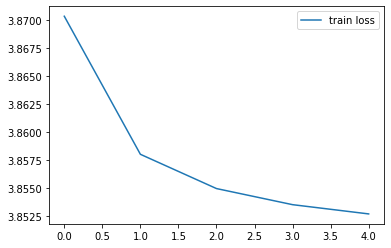

In [18]:
history = model.fit(
  train_loader,
  steps_per_epoch= len(train_dataset) // BATCH_SIZE,
#   validation_data = test_loader,
#   validation_steps = len(test_dataset) // BATCH_SIZE,
  epochs=epochs,
  callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label=f'train loss')
# plt.plot(history.epoch, history.history['val_loss'], label=f'val loss')
plt.legend()
plt.show()

In [19]:
def notes_to_midi(notes, out_file, is_original: bool=False, velocity = 100, step = 0.2, duration = 0.4):

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          "Acoustic Grand Piano")
      )

  prev_start = 0
  for note in notes:
    start = float(prev_start + step)
    end = float(start + duration)
    if is_original is True:
        input_pitch=int(note)
    else:
        input_pitch = int(note)
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=input_pitch,
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

def midi_to_notes(path):
    saved_rolls = 0
    pm = pretty_midi.PrettyMIDI(path)
    notes = []
    try:
        instrument = pm.instruments[0]
    except IndexError:
        print("Skipped")
        return None
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    if len(sorted_notes) > 100:
        prev_start = sorted_notes[0].start
        for note in sorted_notes:
            notes.append(note.pitch)
        saved_rolls = np.array(notes)
    if len(saved_rolls) % 5000 == 0 and len(saved_rolls) != 0:
        files_saved += 1
    return saved_rolls

In [20]:
seed = midi_to_notes('/kaggle/input/mozart-v2/Wolfgang Amadeus Mozart/Mozart Wolfgang Amadeus Allegro in C minor K.Anh.44_426a rGJcCF4aS3c.mid')
input_ids = tf.cast(np.concatenate(([128], seed[100:199])).reshape(1, -1), dtype=tf.int32)
# output = model.generate(seed, max_length = 500, num_beams = 2, temperature = 1, no_repeat_ngram_size=2, num_return_sequences=1)\

outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=200, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=1
)
print(outputs.shape)
generated = outputs[:, 100:]
print(generated)
# original = notes_to_midi(seed, f'original_test.mid', is_original=True) 
# generated = notes_to_midi(predict_sequence(seed, model, num_predictions = 200, temperature = 1), f'generated_test.mid', step = 0.25, duration = 0.4)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 129 (first `eos_token_id`) to generate sequence


(1, 200)
tf.Tensor(
[[63 52 41 63 62 76 74 74 82 82 65 73 59 69 70 57 60 68 64 58 74 65 77 82
  67 65 64 72 79 52 74 50 72 64 48 79 79 70 53 77 68 78 74 81 69 59 74 71
  53 83 67 64 49 50 64 57 67 76 83 72 62 67 73 63 72 64 55 69 59 70 63 79
  55 56 51 69 55 63 78 74 78 51 72 82 61 82 79 65 65 68 52 69 82 48 81 74
  61 51 48 55]], shape=(1, 100), dtype=int32)


In [21]:
notes_to_midi(seed, f'original_test.mid', is_original=True)                                     
notes_to_midi(np.array(generated).reshape(-1), f'generated_test.mid', step = 0.2, duration = 0.4)